# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 декабря 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 декабря, -4 балла после 06:00 13 декабря, -6 баллов после 06:00 20 декабря

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Лозинский".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L1 регуляризацией с помощью метода  Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.
$$ \frac{\partial L}{\partial w_0} = -y_{i}(1 - \sigma(y_{i} g(x_{i}))) $$
$$ \frac{\partial L}{\partial w_j} = -y_{i}x_{ij}(1 - \sigma(y_{i} g(x_{i}))) + \frac{1}{C}sign(w_j) \text{, } j > 0 $$
$i$ - номер обучающего объекта

$j$ - номер коэффициента $w$

## Имплементация (5 баллов)

In [310]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import expit as sigm
from tqdm import tqdm_notebook as tqdm
class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, debug = False):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.debug = debug
        self.los_func = list()
    def _fit(self, X, y=None):
        count = X.shape[0]
        n = X.shape[1]
        y[y == np.unique(y)[0]] = -1
        w = self.w
        w0 = self.w0
        for k in tqdm(xrange(self.epoch, self.epoch + self.max_epoch)):
            debug_sum = 0
            ind = np.random.permutation(count)
            _X = X[ind]
            _y = y[ind]
            ealpha = self.alpha / (k+1)
            for i in xrange(count):
                g = np.dot(_X[i], w)[0] + w0
            
                d = _y[i] * (1 - sigm(_y[i] * g))
                w0 += ealpha  *  (d - np.sign(w0).astype(np.double) / self.C) # с регуляризацией
                w += ealpha * _X[i].reshape(-1, 1) * d - ealpha * np.sign(w).astype(np.double) / self.C
                # print ealpha * _X[i].reshape(-1, 1) * d - ealpha * np.sign(w).astype(np.double) / self.C

            if self.debug:
                for i in xrange(count):
                    debug_sum += np.log(sigm(_y[i] * (np.dot(_X[i], w)[0] + w0)))
            if self.debug:
                self.los_func.append(-1./count * debug_sum + 1./self.C * np.sum(np.abs(w)))
        self.epoch += self.max_epoch
        self.w = w
        self.w0 = w0
        
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        count = X.shape[0]
        n = X.shape[1]
        self.w0 = 1
        self.w = np.ones((n, 1), dtype=np.double)
        self.epoch = 0
        self._fit(X, y)
        return self
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        self._fit(X, y)
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        y_hat_proba = self.predict_proba(X)
        y_hat = np.empty((X.shape[0],)) 
        #if self.debug:
            #print y_hat_proba
        for i in xrange(y_hat.shape[0]):
            if y_hat_proba[i][0] < 0.5:
                y_hat[i] = 0
            else:
                y_hat[i] = 1
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        y_hat_proba = np.empty((X.shape[0], 2))
        for i in xrange(X.shape[0]):
            y_hat_proba[i][0] = sigm(np.dot(X[i], self.w) + self.w0)
            y_hat_proba[i][1] = 1 - y_hat_proba[i][0]
        return y_hat_proba

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

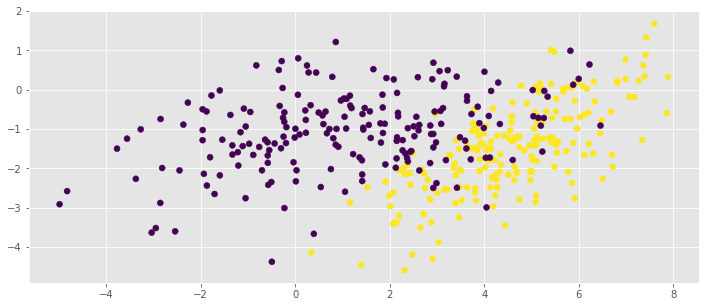

In [326]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]


plt.scatter(X[:,0], X[:,1], c=y)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1


[0.94924364241146786, 0.49157549976324721, 0.35405082419001221, 0.32252270219188645, 0.30587228762972868, 0.35921949147028137, 0.3094838534133198, 0.30774923125253623, 0.3409100186682113, 0.30903497691474979, 0.32776577531736462, 0.31367963891630701, 0.31203997946154921, 0.30838653237091113, 0.32511106710961146, 0.31008689896298619, 0.49598758318347114, 0.36080530207586042, 0.30918094050561429, 0.31330974005381801]
[[ 1.27475635]
 [-1.25191452]]


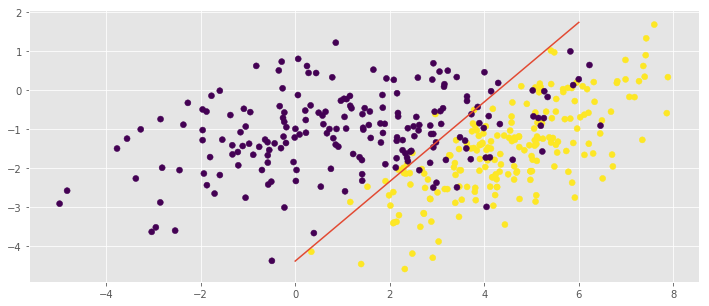

In [314]:
classifier = MySGDClassifier(debug=True, C=100, alpha=0.5, max_epoch=20)
classifier.fit(X, y)
pred = classifier.predict(X)
plt.scatter(X[:,0], X[:,1], c=y)
plt.plot([0, 6], [(-classifier.w0/classifier.w[1]), (-classifier.w0 - classifier.w[0]*6)/classifier.w[1]])
print classifier.los_func
print classifier.w

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [248]:
from sklearn.datasets import make_classification

In [315]:
# Датасет не особо линейно-разделим, ну да ладно...
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

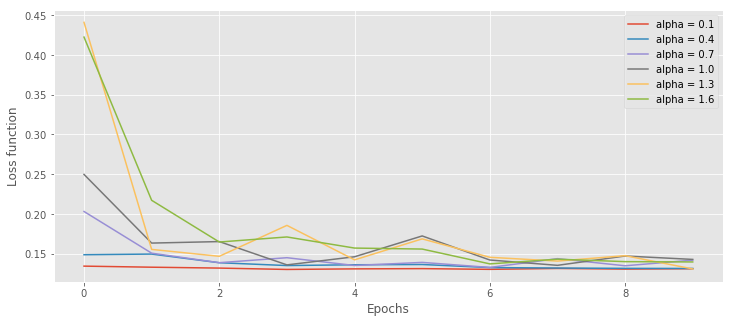

In [257]:
## Your Code Here
epoch_c = 10
for a in np.arange(0.1, 1.8, 0.3):
    classifier = MySGDClassifier(debug=True, C=100, alpha=a, max_epoch=epoch_c)
    classifier.fit(X, y)
    plt.plot(xrange(epoch_c), classifier.los_func, label='alpha = ' + str(a))
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:42: RuntimeWarning: divide by zero encountered in log


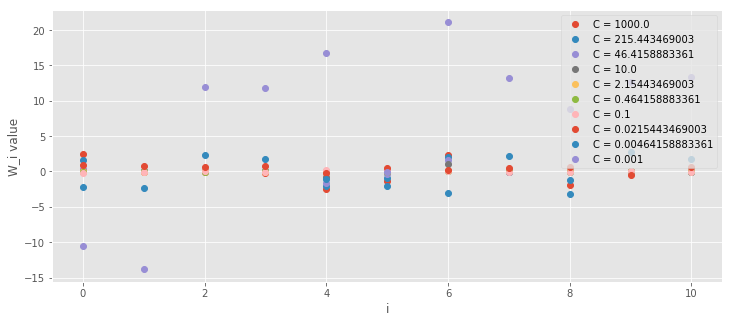

In [283]:
## Your Code Here
epoch_c = 4
for c in np.logspace(3, -3, 10):
    classifier = MySGDClassifier(debug=True, C=c, alpha=0.1, max_epoch=epoch_c)
    classifier.fit(X, y)
    plt.plot(xrange(11), np.concatenate(([[classifier.w0]], classifier.w)).reshape(-1,), label='C = ' + str(c), marker='o', ls ='')
plt.xlabel('i')
plt.ylabel('W_i value')
plt.legend()

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [284]:
# Загрузка данных целиком
df_list = []
for chunk in range(1,5):
    filepath = './trainingData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))
df_data = pd.concat(df_list)

# Загрузка одной части данных
# filepath = './trainingData_tabular_chunk1.csv'
# df_data = pd.read_csv(filepath, sep=',')

In [285]:
df_data.shape

(2000000, 45)

In [286]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [287]:
df_data.head().T

gamestate_id,4687346.0,3270826.0,3189487.0,4098946.0,2661127.0
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [288]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.5047995

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [ ]:
## Youd Code Here
print "Количество уникальных карт героя у игрока: ",df_data.player_hero_card_id.nunique()
print "Количество уникальных карт героя у игрока: ",df_data.opponent_hero_card_id.nunique()

In [291]:
df_dummies = pd.get_dummies(df_data, columns=['opponent_hero_card_id', 'player_hero_card_id'])
df_dummies.head().T

gamestate_id,4687346.0,3270826.0,3189487.0,4098946.0,2661127.0
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1
opponent_deck_count,11,19,22,17,12


In [338]:
print df_dummies.shape

(2000000, 60)


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [316]:
## Youd Code Here
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X_train, y_train = df_dummies.iloc[:,1:].values, df_dummies.iloc[:, :1].values

hs_classifier = MySGDClassifier(alpha=5, max_epoch=20, C=40)
pipe = Pipeline([('scaler', StandardScaler()),('classifier', hs_classifier)])
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', MySGDClassifier(C=40, alpha=5, debug=False, max_epoch=20))])

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [331]:
## Youd Code Here
df_list_test = []
for chunk in range(5,8):
    filepath = './testData_tabular_chunk%d.csv' % chunk
    df_list_test.append(pd.read_csv(filepath, sep=','))
df_data_test = pd.concat(df_list_test)
df_dummies_test = pd.get_dummies(df_data_test, columns=['opponent.hero_card_id', 'player.hero_card_id'])

In [343]:
X_test, y_test = df_dummies_test.iloc[:,2:].values, pd.read_csv('./deprecated_testLabels.txt', header=None).values

In [345]:
from sklearn.metrics import roc_auc_score
y_pred = pipe.predict(X_test)
score = roc_auc_score(y_test, y_pred)
print score

0.590211474748
